The manual annotations are compared with the annotation by Gemini

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# get the annotations 

In [2]:
import pandas as pd

t5_manual = pd.read_csv('T5_manual_scores.csv')
t5_gemini = pd.read_csv('T5_gemini_scores_all_texts.csv')

bt_manual = pd.read_csv('Back_translation_manual_scores.csv')
bt_gemini = pd.read_csv('Back_translation_gemini_scores_all_texts.csv')

bart_manual = pd.read_csv('bart_manual_scores.csv')
bart_gemini = pd.read_csv('Bart_gemini_scores_all_texts.csv')

# weighted sum of the scores of the chunks for each text

In [3]:
def compute_scores(df_manual, df_gemini):
    #weight for the fixed sentence > weights of other sentences
    weights = [1.5, 1, 1]
    
    #weighted sum of the annotations
    df_manual = df_manual.copy()
    df_manual['manual_score'] = df_manual[['score_fixed', 'score_random_1', 'score_random_2']].apply(
        lambda row: (row['score_fixed'] * weights[0] + row['score_random_1'] * weights[1] + row['score_random_2'] * weights[2]) / sum(weights),
        axis=1)
    
    # weight for the chunks
    df_gemini = df_gemini.copy()
    df_gemini['weight'] = df_gemini['chunk_index'].apply(lambda x: 1.5 if x == 0 else 1)
    
    #weighted average of scores given by gemini
    gemini_scores = df_gemini.groupby('text_index').apply(
        lambda g: (g['score'] * g['weight']).sum() / g['weight'].sum()
    ).reset_index(name='gemini_score')
    

    result = gemini_scores.merge(df_manual[['text_index', 'manual_score']], on='text_index')
    
    return result


# T5

In [6]:
scores_t5 = compute_scores(t5_manual, t5_gemini)
scores_t5.head()

,text_index,gemini_score,manual_score
0,0,3.444444,3.000000
1,1,3.222222,2.857143
2,2,3.592593,2.714286
3,3,3.629630,4.571429
4,4,3.481481,4.000000


In [4]:
scores_t5 = compute_scores(t5_manual, t5_gemini)
correlation_t5 = scores_t5['manual_score'].corr(scores_t5['gemini_score'])

print(f"Correlation t5 (Pearson) : {correlation_t5:.3f}")

Correlation t5 (Pearson) : 0.108


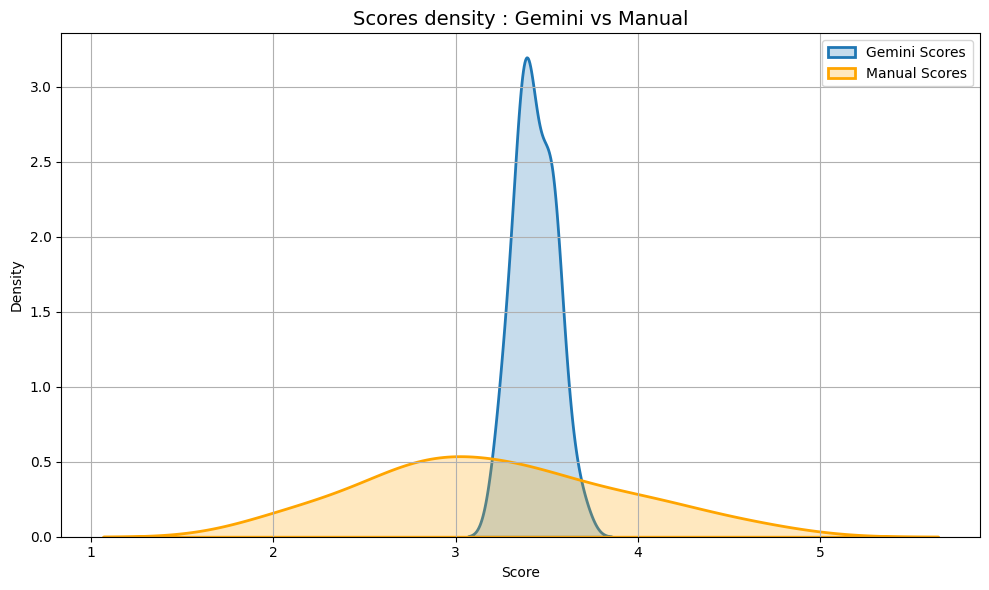

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = scores_t5.copy()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['gemini_score'], label='Gemini Scores', fill=True, linewidth=2)
sns.kdeplot(df['manual_score'], label='Manual Scores', fill=True, linewidth=2, color='orange')
plt.title("Scores density : Gemini vs Manual", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Back translation

In [7]:
scores_bt = compute_scores(bt_manual, bt_gemini)
correlation_bt = scores_bt['manual_score'].corr(scores_bt['gemini_score'])
print(f"Correlation back translation (Pearson) : {correlation_bt:.3f}")

Correlation back translation (Pearson) : 0.077


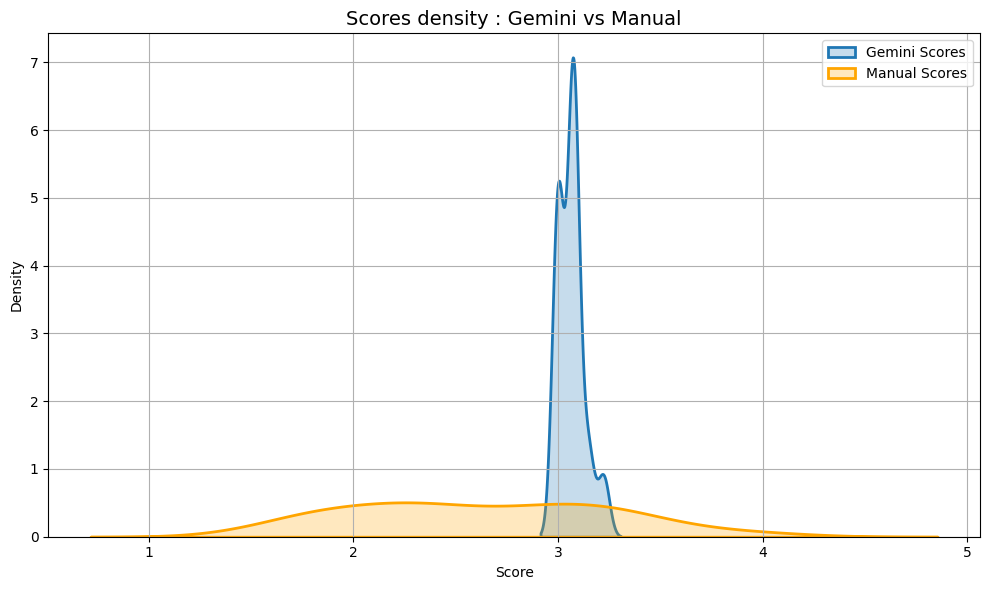

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = scores_bt.copy()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['gemini_score'], label='Gemini Scores', fill=True, linewidth=2)
sns.kdeplot(df['manual_score'], label='Manual Scores', fill=True, linewidth=2, color='orange')
plt.title("Scores density : Gemini vs Manual", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Bart

In [8]:
scores_bart = compute_scores(bart_manual, bart_gemini)
correlation_bart = scores_bart['manual_score'].corr(scores_bart['gemini_score'])
print(f"Correlation back translation (Pearson) : {correlation_bart:.3f}")

Correlation back translation (Pearson) : 0.123


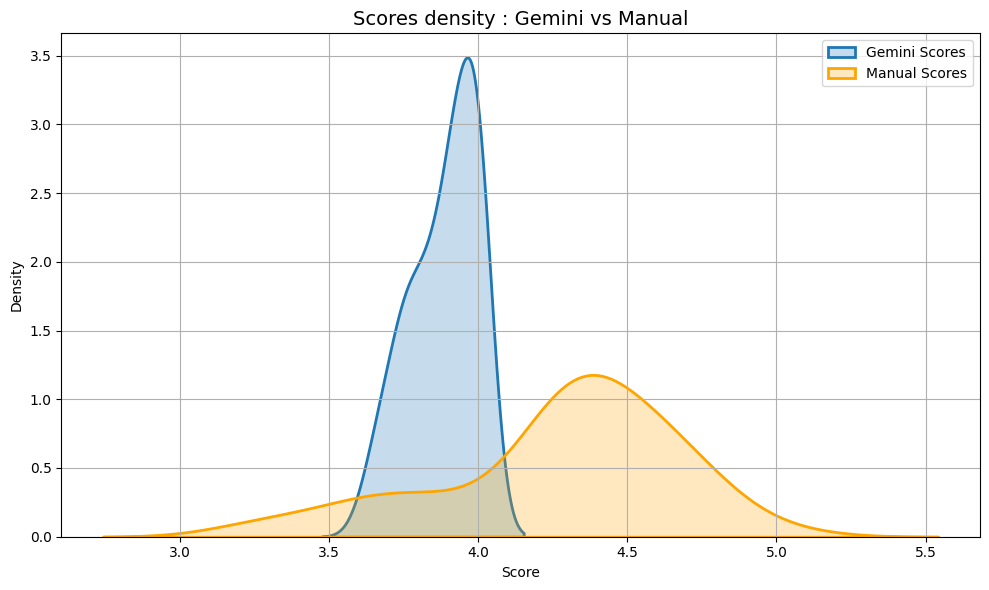

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = scores_bart.copy()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['gemini_score'], label='Gemini Scores', fill=True, linewidth=2)
sns.kdeplot(df['manual_score'], label='Manual Scores', fill=True, linewidth=2, color='orange')
plt.title("Scores density : Gemini vs Manual", fontsize=14)
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()